<a href="https://colab.research.google.com/github/harmishpatel21/forecasting-crypto/blob/main/Data_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas_datareader
!pip install yfinance
!pip install sklearn

     |████████████████████████████████| 5.5MB 11.3MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=99b11f298d591d35bf307c0264beab2b1cbdbfd96cf4cc0840a3b0d005bdffb2
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

In [3]:
from pandas_datareader import data as pdr
from datetime import date
import yfinance as yf
yf.pdr_override()
import pandas as pd

In [61]:
ticker = "ETH-BTC"
startDate = "2010-01-01"
EndDate = "2021-04-14"
today = date.today()

In [62]:
files=[]
data = pdr.get_data_yahoo(ticker, start=startDate, end=today)
print(type(data))
print(data.shape)
data.head()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
(571, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-09-18,0.020315,0.021250,0.020401,0.020728,0.020728,901590
2019-09-19,0.020714,0.021709,0.019937,0.021554,0.021554,1034448
2019-09-20,0.021533,0.021765,0.021132,0.021416,0.021416,788475
2019-09-21,0.021401,0.022052,0.021458,0.021509,0.021509,772807
2019-09-22,0.021506,0.021458,0.020619,0.021007,0.021007,775824


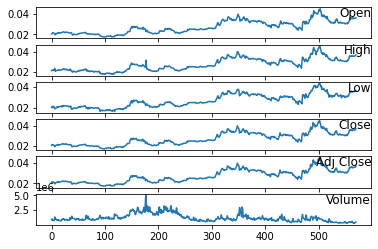

In [63]:
values = data.values
groups = [0,1,2,3,4,5]
i = 1
plt.figure()
for group in groups:
  plt.subplot(len(groups),1,i)
  plt.plot(values[:, group])
  plt.title(data.columns[group], y = 0.5, loc = 'right')
  i += 1
plt.show()

In [64]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [65]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()

  for i in range(n_in, 0 , -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    if dropnan:
      agg.dropna(inplace = True)
    return agg

In [66]:
encoder = LabelEncoder()
values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1,1)
reframed.head()
reframed.drop(reframed.columns[[7,8,9,10,11]], axis = 1, inplace = True)

In [67]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
1,0.105939,0.128497,0.151885,0.120903,0.120903,0.128387,0.120370
2,0.120370,0.144529,0.134616,0.150750,0.150750,0.156585,0.149993
3,0.149993,0.146485,0.179091,0.145763,0.145763,0.104380,0.145218
4,0.145218,0.156509,0.191224,0.149124,0.149124,0.101054,0.149016
5,0.149016,0.135762,0.159999,0.130985,0.130985,0.101694,0.131547


In [68]:
len(reframed)

570

In [69]:
values = reframed.values
n_train = 365
train = values[:n_train,:]
test = values[n_train:,:]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(365, 1, 6) (365,) (205, 1, 6) (205,)


In [70]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history


Epoch 1/50
6/6 - 2s - loss: 0.2497 - val_loss: 0.5115
Epoch 2/50
6/6 - 0s - loss: 0.2102 - val_loss: 0.4528
Epoch 3/50
6/6 - 0s - loss: 0.1730 - val_loss: 0.3931
Epoch 4/50
6/6 - 0s - loss: 0.1372 - val_loss: 0.3323
Epoch 5/50
6/6 - 0s - loss: 0.1054 - val_loss: 0.2717
Epoch 6/50
6/6 - 0s - loss: 0.0831 - val_loss: 0.2142
Epoch 7/50
6/6 - 0s - loss: 0.0724 - val_loss: 0.1646
Epoch 8/50
6/6 - 0s - loss: 0.0681 - val_loss: 0.1223
Epoch 9/50
6/6 - 0s - loss: 0.0680 - val_loss: 0.0913
Epoch 10/50
6/6 - 0s - loss: 0.0691 - val_loss: 0.0722
Epoch 11/50
6/6 - 0s - loss: 0.0674 - val_loss: 0.0614
Epoch 12/50
6/6 - 0s - loss: 0.0629 - val_loss: 0.0552
Epoch 13/50
6/6 - 0s - loss: 0.0569 - val_loss: 0.0509
Epoch 14/50
6/6 - 0s - loss: 0.0504 - val_loss: 0.0468
Epoch 15/50
6/6 - 0s - loss: 0.0438 - val_loss: 0.0413
Epoch 16/50
6/6 - 0s - loss: 0.0376 - val_loss: 0.0342
Epoch 17/50
6/6 - 0s - loss: 0.0318 - val_loss: 0.0254
Epoch 18/50
6/6 - 0s - loss: 0.0262 - val_loss: 0.0170
Epoch 19/50
6/6 - 0

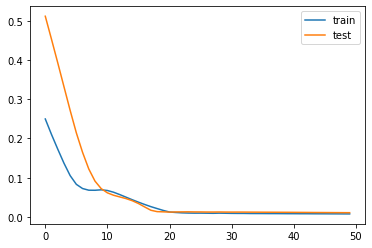

In [71]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [72]:
from numpy import concatenate
from math import sqrt
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.000


In [ ]:
# data.index = data.index.to_period('D')
# X = data.values
# X

array([[4.65864014e+02, 4.68174011e+02, 4.52421997e+02, 4.57334015e+02,
        4.57334015e+02, 2.10568000e+07],
       [4.56859985e+02, 4.56859985e+02, 4.13104004e+02, 4.24440002e+02,
        4.24440002e+02, 3.44832000e+07],
       [4.24102997e+02, 4.27834991e+02, 3.84532013e+02, 3.94795990e+02,
        3.94795990e+02, 3.79197000e+07],
       ...,
       [5.89302773e+04, 5.99300273e+04, 5.77264180e+04, 5.89188320e+04,
        5.89188320e+04, 6.55208262e+10],
       [5.89265625e+04, 5.95860703e+04, 5.85052773e+04, 5.90958086e+04,
        5.90958086e+04, 6.16691638e+10],
       [5.98927070e+04, 6.02549531e+04, 5.89024688e+04, 5.92287773e+04,
        5.92287773e+04, 5.72050309e+10]])

In [6]:
data=data.reset_index()
data = data[['Date','Open','High','Low','Volume','Close']]
data.head()

,Date,Open,High,Low,Volume,Close
0,2014-09-17,465.864014,468.174011,452.421997,21056800,457.334015
1,2014-09-18,456.859985,456.859985,413.104004,34483200,424.440002
2,2014-09-19,424.102997,427.834991,384.532013,37919700,394.795990
3,2014-09-20,394.673004,423.295990,389.882996,36863600,408.903992
4,2014-09-21,408.084991,412.425995,393.181000,26580100,398.821014


In [7]:
X = data.iloc[:, :-1]
Y = data.iloc[:, -1]

In [8]:
size = int(len(data) * 0.7)
print(size)


1678


In [9]:
train = data.iloc[:size, :]
test = data.iloc[size:,:]


In [10]:
train_X = train.iloc[:, :-1]
train_Y = train.iloc[:, -1]
test_X = test.iloc[:, :-1]
test_Y = test.iloc[:, -1]
print(train_X.shape,train_Y.shape,test_X.shape,test_Y.shape)

(1678, 5) (1678,) (720, 5) (720,)


In [ ]:
# # X = data.values
# size = int(len(X) * 0.66)
# train = X.iloc[:size, :]
# test = X.iloc[size:, :]

# train_X, train_y = train[:, :-1], train[:, -1]
# test_X, test_y = test[:, :-1], test[:, -1]

TypeError: ignored

In [ ]:
history = [x for x in train_X]
predictions = list()



In [ ]:
!pip install statsmodels

In [11]:
import xgboost as xgb
import numpy as np
dtrain = xgb.DMatrix(train_X, label=train_Y, missing=np.nan)

param = {'objective': 'reg:linear', 'booster': 'gbtree', 'silent': 1,
         'max_depth': 100, 'eta': 0.1, 'nthread': 4,
         'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 5,
         'max_delta_step': 0, 'gamma': 0}
num_round = 200
clf = xgb.train(param, dtrain, num_round)
dtest = xgb.DMatrix(test_X, missing=np.nan)
test_preds = clf.predict(dtest)

ValueError: ignored

In [ ]:
## Loss functions calculation
rmse = 0
count=0
for i in test_preds:
    rmse += (i - test_y['Close'][count])**2
    count+=1
print((rmse/len(Y_test))**(1/2))

In [ ]:
print(max(data['Date']), min(data['Date']))

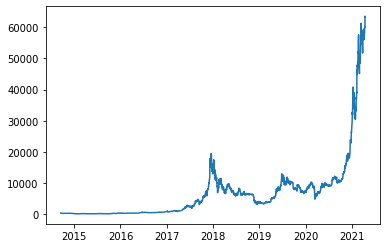

In [12]:
plt.plot(data['Date'],data['Close'])

In [14]:
df=data
# df['Date'] = df['Date'].apply(lambda x: date(x))
type(df['Date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [ ]:
from pandas._libs.tslibs.timestamps import Timestamp
df['Date'] = df['Date'].apply(lambda x: str(Timestamp(x, freq='MS')).split()[0])
# print(str(ts).split()[0])
type(df['Date'][0])
# ts = Timestamp('2018-12-01', freq='MS')
# date_time = ts.to_pydatetime()

In [ ]:
df.head()

In [ ]:
# import tensorflow as tf
# import numpy as np
# df1 = df[['Open','High','Low','Close', 'Adj Close', 'Volume']]
# for i in df1.columns:
#   df[i] = df1[i].apply(lambda x: tf.convert_to_tensor(x, np.float32))

In [15]:
for i in df.columns:
  print(type(df[i][0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.int64'>
<class 'numpy.float64'>


In [16]:
# split into train and test sets
values = df.values

n_train_time = 365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(2398, 1, 5) (2398,) (0, 1, 5) (0,)


In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import datetime

In [ ]:
model = ARIMA(df, order=(1,0,1)) # (ARMA) = (1,0,1)
model_fit = model.fit(disp=0)

ValueError: ignored

In [ ]:
train_X.shape
# train_Y
# test_X
# test_Y

(1670, 5)

In [17]:
model = Sequential()
model.add(LSTM(100, input_shape=(1, 5)))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_Y, epochs=20, batch_size=70, validation_data=(test_X, test_Y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: ignored

In [ ]:
for i in data.columns:
  print(type(data[i][0]))

In [ ]:
train_mean = train_df.mean()
print(type(train_mean))

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)